In [2]:
import Pkg; Pkg.activate("C:/Users/a7b/Pico.jl"); Pkg.instantiate()

  Activating project at `C:\Users\a7b\Pico.jl`


In [3]:
using Pico
using PyPlot
using QuantumOptics
using ForwardDiff
using Interpolations
using LinearAlgebra
using SparseArrays
using OSQP

In [4]:
WDIR = joinpath(@__DIR__, "../../")
include(joinpath(WDIR, "experiments", "ilqoc", "measurement.jl"))

exp_frechet!

In [335]:
iter = 3000

ω = 2π * 4.96 #GHz
α = -2π * 0.143 #GHz
levels = 2

ψg = [1. + 0*im, 0]
ψe = [0, 1. + 0*im]

ψ1 = [ψg, ψe]
ψf = [-im*ψe, -im*ψg]

H_drift = α/2 * Pico.quad(levels)
H_drive = [Pico.create(levels) + Pico.annihilate(levels),
1im * (Pico.create(levels) - Pico.annihilate(levels))]

sys = QuantumSystem(
    H_drift, 
    H_drive,
    ψ1 = ψ1,
    ψf = ψf,
    control_bounds = [2π * 19e-3,  2π * 19e-3]
);

In [375]:
T = 400
Δt = 0.1
Q = 200.
R = 0.1
cost = infidelity_cost
hess = true
pinqstate = true

time = T * Δt

options = Options(
    max_iter = iter,
    tol = 1e-5
)

prob = QuantumControlProblem(
    sys,
    T;
    Δt = Δt,
    Q = Q,
    R = R,
    eval_hessian = hess,
    cost = cost,
    pin_first_qstate = pinqstate,
    options = options
);

In [376]:
#this will give us the nominal trajectory that we need to track
solve!(prob)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    36634
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    14723

Total number of variables............................:     5580
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      796
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4788
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9676497e-01 4.41e-01 9.16e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [377]:
#Extract the solution
Xopt = prob.trajectory.states
Uopt = prob.trajectory.actions

for i = 1:length(Xopt)
    x = Xopt[i]
    meas = zeros(0)
    for s = 1:sys.nqstates
        iso_state = x[slice(s, sys.isodim)]
        append!(meas, meas_x_iso(iso_state))
        append!(meas, meas_y_iso(iso_state))
        append!(meas, meas_z_iso(iso_state))
    end
    Xopt[i] = [x[1:sys.n_wfn_states]; meas; x[(sys.n_wfn_states + 1):end]]
end


In [378]:
n = sys.nstates + 3*sys.nqstates
print(n)
m = sys.ncontrols

xnom = zeros(n, prob.T)

for k = 1:prob.T
    xnom[:, k] .= Xopt[k]
end

unom = zeros(m, prob.T - 1)
utraj = zeros(m, prob.T - 1)

for k = 1:prob.T - 1
    unom[:, k] .= Uopt[k]
    utraj[:, k] .= Uopt[k]
end



18

In [379]:
function discrete_dynamics(x, u)
    G = sys.G_drift + x[15] * sys.G_drives[1] + x[16] * sys.G_drives[2]
    h_prop = exp(G * Δt)
    state1_ = x[1:4]
    state2_ = x[5:8]
    state1 = h_prop * state1_
    state2 = h_prop * state2_
    meas_1 = [meas_x_iso(state1), meas_y_iso(state1), meas_z_iso(state1)]
    meas_2 = [meas_x_iso(state2), meas_y_iso(state2), meas_z_iso(state2)]
    controls = x[15:16] + x[17:18] .* Δt
    dcontrols = x[17:18] + u[1:2] .* Δt
    return [state1; state2; meas_1; meas_2; controls; dcontrols]
end

function true_dynamics(x, u)
    G = sys.G_drift + 0.01*get_mat_iso(-1im * sigmaz()) + u[1] * sys.G_drives[1] + u[2] * sys.G_drives[2]
    h_prop = exp(G * Δt)
    state1_ = x[1:4]
    state2_ = x[5:8]
    state1 = h_prop * state1_
    state2 = h_prop * state2_
    meas_1 = [meas_x_iso(state1), meas_y_iso(state1), meas_z_iso(state1)]
    meas_2 = [meas_x_iso(state2), meas_y_iso(state2), meas_z_iso(state2)]
    controls = x[15:16] + x[17:18] .* Δt
    dcontrols = x[17:18] + u[1:2] .* Δt
    return [state1; state2; meas_1; meas_2; controls; dcontrols]
end


true_dynamics (generic function with 1 method)

In [380]:
#Compute linearization of dynamics using nominal dynamics + trajectory

A = zeros(n, n, T-1)
B = zeros(n, m, T-1)  

for k = 1:(T-1)
    A[:, :, k] .= ForwardDiff.jacobian(x->discrete_dynamics(x, Uopt[k]), Xopt[k])
    B[:, :, k] .= ForwardDiff.jacobian(u->discrete_dynamics(Xopt[k], u), Uopt[k])
end    

In [381]:
basis = GenericBasis(2)
ketψg = Ket(basis, ψg)
ketψe = Ket(basis, ψe)

σx_noisy = Operator(basis, basis, noisy_sigmax(error = 0.13))
σy_noisy = Operator(basis, basis, noisy_sigmay(error = 0.13))

Operator(dim=2x2)
  basis: Basis(dim=2)
 0.104095+0.0im             0.0-0.994567im
      0.0+0.994567im  -0.104095+0.0im

In [477]:
xtraj = zeros(n, T)
xtraj[17, :] .= [0. ; cumsum(utraj[1, :]*Δt)]
xtraj[18, :] .= [0. ; cumsum(utraj[2, :]*Δt)]
xtraj[15, :] .= [0.;cumsum(xtraj[17, :]*Δt)][1:end-1]
xtraj[16, :] .= [0.;cumsum(xtraj[18, :]*Δt)][1:end-1];

In [478]:
tspan = 0.0:Δt:39.9
uint_1 = constant_interpolation(tspan, xtraj[15,:])
uint_2 = constant_interpolation(tspan, xtraj[16,:]);

In [479]:
basis = GenericBasis(2)
ketψg = Ket(basis, ψg)
ketψe = Ket(basis, ψe)

#True dynamics with Lindblad master equation
Ts = [tspan;]
T1 = 100e1/3
T2 = 150e1/3
nth = 0.015
rates = [1/T1 * (1+nth), 1/T1 * nth, 1/T2 - 1/2/T1]
J = [Operator(basis, basis, Pico.annihilate(2)), Operator(basis, basis, Pico.create(2)),
     Operator(basis, basis, Pico.number(2))]
Jdagger = dagger.(J)

function f(t, ρ)
    Hop = Operator(basis, basis, H_drift + uint_1(t)*H_drive[1] + uint_2(t) * H_drive[2])
    return Hop, J, Jdagger
end

toutg, ρgt = timeevolution.master_dynamic(Ts, ketψg, f, rates = rates)
toute, ρet = timeevolution.master_dynamic(Ts, ketψe, f, rates = rates)

expectxg = real(expect(σx_noisy, ρgt))
expectyg = real(expect(σy_noisy, ρgt))
expectzg = real(expect(Operator(basis, basis, sigmaz()), ρgt))

expectxe = real(expect(σx_noisy, ρet))
expectye = real(expect(σy_noisy, ρet))
expectze = real(expect(Operator(basis, basis, sigmaz()), ρet))


400-element Vector{Float64}:
 -1.0
 -0.9993910940808095
 -0.998640012919534
 -0.9968933236347359
 -0.9940111691277684
 -0.9899973890911706
 -0.9856617052002163
 -0.9832286477276101
 -0.9824131386040843
 -0.9815395516710071
 -0.9806057642044309
 -0.979605371700358
 -0.9785308935896834
  ⋮
  0.8964956952259415
  0.8959579140087237
  0.8954543566678624
  0.894992243838575
  0.8945810856155877
  0.8942278293262479
  0.8939352204913282
  0.8937061670387195
  0.8935433007040571
  0.8934445334075485
  0.8934037275725992
  0.8934253682369813

In [480]:
xtraj[1:8, :] .= xnom[1:8, :]
xtraj[9, :] .= expectxg
xtraj[10,:] .= expectyg
xtraj[11, :] .= expectzg
xtraj[12, :] .= expectxe
xtraj[13, :] .= expectye
xtraj[14, :] .= expectze;

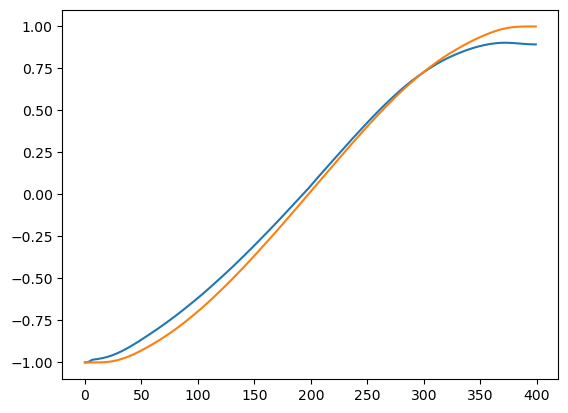

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000008B9EBA58>

In [481]:
plot(xtraj[14, :])
plot(xnom[14, :])

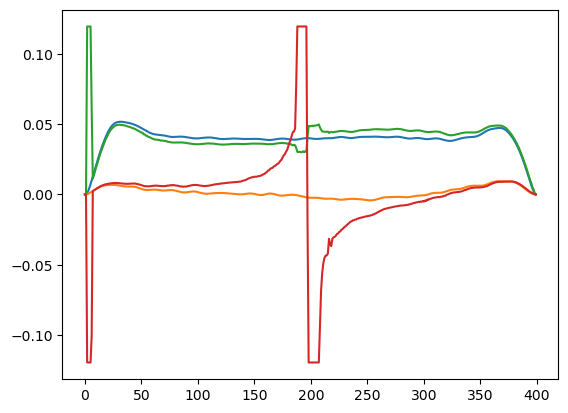

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000008BA7E208>

In [482]:
plot([Xopt[i][15:16] for i = 1:length(Xopt)])
plot(xtraj[15,:])
plot(xtraj[16, :])

In [483]:
#Set up the ILC QP

#Cost   
Qf = Diagonal([fill(0., sys.isodim*sys.nqstates); [0, 0, 8000.]; [0., 0., 8000.]; fill(0., 4)])

Qilc = sparse(Diagonal([fill(0., sys.isodim*sys.nqstates); fill(1., 3*sys.nqstates); fill(0., 4)]))

Rilc = sparse(Diagonal([0.00, 0.00]))
H = blockdiag(kron(I(T-2), blockdiag(Rilc, Qilc)), Rilc, sparse(Qf))
q = zeros((n+m)*(T-1))
for k = 1:(T-2)
   q[(k-1)*(m+n) .+ (1:(m+n))] .= [zeros(sys.ncontrols); Qilc*(xtraj[:,k+1] - Xopt[k+1])] 
end
q[(T-2)*(m+n) .+ (1:(m+n))] .= [zeros(sys.ncontrols); Qf*(xtraj[:,T] - Xopt[T])]

display(xtraj[:,T] - Xopt[T])

#Constraints
U = kron(I(T-1), [I zeros(m,n)]) #Matrix that picks out all u
C = kron(I(T-1), [zeros(m,16) I zeros(m,2)]) #picks out all cntrls
X = kron(I(T-1), [zeros(n,m) I]) #Matrix that picks out all x
D = spzeros(n*(T-1), (n+m)*(T-1)) #dynamics constraints

D[1:n,1:m] .= B[:,:,1]
D[1:n,(m+1):(m+n)] .= -I(n)
for k = 1:(T-2)
    D[(k*n).+(1:n), (m+(k-1)*(n+m)).+(1:(2*n+m))] .= [A[:,:,k+1] B[:,:,k+1] -I]
end 

c_bnd = [fill(2π*19e-3, 2*(T-2)); zeros(2)]
ctrajF = reduce(vcat, xtraj[15:16,2:end])
lb = [zeros(n*(T-1)); -c_bnd-ctrajF]
ub = [zeros(n*(T-1)); c_bnd-ctrajF]

qp = OSQP.Model()
OSQP.setup!(qp, P=H, q=q, A=[D; C], l=lb, u=ub, eps_abs=1e-8, eps_rel=1e-8, eps_prim_inf = 1.0e-8, eps_dual_inf = 1.0e-8, polish=1)
results = OSQP.solve!(qp)
ztraj = results.x;

18-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.0024577866744122656
 -0.06907201670844668
  0.10097293716772082
 -0.0020689948861749366
 -0.0689824344972211
 -0.10657463176301873
 -2.5680846338360652e-14
  9.462916561453483e-16
  0.00021398465186435456
  4.270808778403072e-5

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7980, constraints m = 7980
          nnz(P) + nnz(A) = 51331
settings: linear system solver = qdldl,
          eps_abs = 1.0e-008, eps_rel = 1.0e-008,
          eps_prim_inf = 1.0e-008, eps_dual_inf = 1.0e-008,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter  objective    pri res    dua res    rho        time
   1 -5.7212e+001  1.06e-002  5.12e+002  1.00e-001  2.53e-002s
 200 -7.7738e-006  2.07e-011  1.62e-004  5.93e+001  1.99e-001s
 400 -7.8215e-006  6.08e-012  8.70e-0

In [484]:
Δu = reshape(U*ztraj, 2, :)
display(Δu[:, 20:60])
display(utraj[:, 20:60])
utraj = utraj+Δu
display(utraj[:, 20:60])

2×41 Matrix{Float64}:
  0.00546338  -0.00150447  -0.00247707  …  -0.00117012   -0.00061595
 -0.00105594   4.05467e-5   0.00165574     -0.000680193  -0.000152768

2×41 Matrix{Float64}:
 -0.0373846  0.00607403  -0.0403439  -0.0158185   …   0.00313797  0.0195944
 -0.010675   0.0108708   -0.011477   -0.00275569     -0.00218327  0.00158855

2×41 Matrix{Float64}:
 -0.0319213  0.00456955  -0.042821    -0.0130362   …   0.00196785  0.0189785
 -0.011731   0.0109114   -0.00982126  -0.00515281     -0.00286347  0.00143578